In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define your target columns
TARGET_COLS = [
    'toxicity', 
    'severe_toxicity', 
    'obscene', 
    'threat', 
    'insult', 
    'identity_attack', 
    'sexual_explicit'
]

df_test=pd.read_parquet("/kaggle/input/civil-comments/test-00000-of-00001.parquet")

df_train1=pd.read_parquet("/kaggle/input/civil-comments/train-00000-of-00002.parquet")
df_train2=pd.read_parquet("/kaggle/input/civil-comments/train-00001-of-00002.parquet")

df_val=pd.read_parquet("/kaggle/input/civil-comments/validation-00000-of-00001.parquet")

df = pd.concat([df_test, df_train1, df_train2, df_val], ignore_index=True)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train_df

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
285827,Vote the judges out!,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
999752,We Alaskans are at a fork in the road; we can ...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
716000,"I asked for links a couple of hours ago, all I...",0.111111,0.0,0.0,0.0,0.000000,0.0,0.0
915483,This is just excellent news. Sounds like they ...,0.142857,0.0,0.0,0.0,0.142857,0.0,0.0
106883,while this is completely off subject from this...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
259178,"""Members of the Port Angeles Citizen Action Ne...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1414414,boots stop harping on trump about his tax retu...,0.400000,0.0,0.0,0.3,0.000000,0.0,0.0
131932,Because the Department of the Interior isn't a...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
671155,Even publishing the fake quotation is false ad...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [8]:
val_df

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
1787647,California is too broke to secede and will be ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118407,I do agree about the map comment but I'm also ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162872,I am so very glad that you wrote in with your ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1688827,What the Puerto Ricans need to do is to incorp...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1068446,It's more like NATO's goal of damaging Russia ...,0.3,0.0,0.0,0.1,0.2,0.1,0.0
...,...,...,...,...,...,...,...,...
439729,Very generous gift. I hope they use it wisely.,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203458,And who said anything about the people not mov...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1685972,"This happens approx every 18 months in the US,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
477501,Ontario targets hard-working doctors in new bu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample_df = train_df.sample(n=70000, random_state=42)
train_df = sample_df
sample_df = val_df.sample(n=14000, random_state=42)
val_df = sample_df

In [ ]:
class ToxicityDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        targets = self.targets[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.FloatTensor(targets)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = ToxicityDataset(
    train_df['text'].values,
    train_df[TARGET_COLS].values,
    tokenizer
)

val_dataset = ToxicityDataset(
    val_df['text'].values,
    val_df[TARGET_COLS].values,
    tokenizer
)

In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [9]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 33.1 MB/s eta 0:00:00:00:0100:01


In [1]:
class ToxicityRegressor(torch.nn.Module):
    def __init__(self, n_classes):
        super(ToxicityRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(p=0.2)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = torch.nn.Sigmoid()  # Since your targets are between 0-1
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return self.sigmoid(output)

# model = ToxicityRegressor(len(TARGET_COLS))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# Initialize model
model = ToxicityRegressor(len(TARGET_COLS))

# Multi-GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()

print(f"Number of GPUS: {n_gpus}")

if n_gpus > 1:
    print(f"Using {n_gpus} GPUs!")
    model = torch.nn.DataParallel(model)
    
model = model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Number of GPUS: 2
Using 2 GPUs!


In [ ]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.MSELoss()  # Mean Squared Error loss for regression

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    
    for batch in tqdm(data_loader, desc='Training'):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(losses)

def eval_epoch(model, data_loader, device):
    model.eval()
    losses = []
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    
    # Calculate MAE for each target
    mae_scores = {}
    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)
    
    for i, col in enumerate(TARGET_COLS):
        mae_scores[col] = mean_absolute_error(
            all_targets[:, i], 
            all_outputs[:, i]
        )
    
    return np.mean(losses), mae_scores

In [ ]:
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_mae': []}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae = eval_epoch(model, val_loader, device)
    
    print(f'Train loss: {train_loss:.4f}')
    print(f'Val loss: {val_loss:.4f}')
    print('Validation MAE:')
    for k, v in val_mae.items():
        print(f'  {k}: {v:.4f}')
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.bin')
        best_val_loss = val_loss

In [ ]:
def predict_toxicity(text, model, tokenizer, device, max_len=128):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
    
    outputs = outputs.cpu().flatten().numpy()
    return dict(zip(TARGET_COLS, outputs))

# Example usage
sample_text = "this is a toxic comment"
predictions = predict_toxicity(sample_text, model, tokenizer, device)

print("Toxicity Predictions:")
for k, v in predictions.items():
    print(f"{k}: {v:.4f}")

SAVE THE MODEL TO REUSE

In [ ]:
import os
import json
import torch

# Create directory if it doesn't exist
os.makedirs('/kaggle/working/toxicity_model', exist_ok=True)

# 1. Save model weights (handle DataParallel wrapping)
if isinstance(model, torch.nn.DataParallel):
    # If using multiple GPUs, get the underlying model
    torch.save(model.module.state_dict(), '/kaggle/working/toxicity_model/pytorch_model.bin')
    # Get the config from the underlying BERT model
    bert_config = model.module.bert.config
else:
    torch.save(model.state_dict(), '/kaggle/working/toxicity_model/pytorch_model.bin')
    bert_config = model.bert.config

# 2. Save model configuration
bert_config.save_pretrained('/kaggle/working/toxicity_model')

# 3. Save tokenizer
tokenizer.save_pretrained('/kaggle/working/toxicity_model')

# 4. Save target columns
with open('/kaggle/working/toxicity_model/target_columns.json', 'w') as f:
    json.dump(TARGET_COLS, f)

print("Model saved successfully in '/kaggle/working/toxicity_model' directory")

LOAD THE MODEL

In [1]:
from transformers import BertConfig, BertTokenizer
import json
import torch
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
from transformers import BertTokenizer, BertModel
# from torch.optim import AdamW
# from torch.utils.data import Dataset, DataLoader
# from tqdm import tqdm

class ToxicityRegressor(torch.nn.Module):
    def __init__(self, n_classes):
        super(ToxicityRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(p=0.2)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = torch.nn.Sigmoid()  # Since your targets are between 0-1
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return self.sigmoid(output)

def load_toxicity_model(model_dir, device):
    """Load the model from saved files"""
    # 1. Load configuration
    config = BertConfig.from_pretrained(model_dir)
    
    # 2. Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_dir)
    
    # 3. Load target columns
    with open(f'{model_dir}/target_columns.json', 'r') as f:
        target_cols = json.load(f)
    
    # 4. Initialize model architecture
    model = ToxicityRegressor(len(target_cols))
    
    # 5. Load weights (map to device if needed)
    state_dict = torch.load(f'{model_dir}/pytorch_model.bin', map_location=device)
    model.load_state_dict(state_dict) 

    n_gpus = torch.cuda.device_count()
    print(f"Number of GPUS: {n_gpus}")
    if n_gpus > 1:
        print(f"Using {n_gpus} GPUs!")
        model = torch.nn.DataParallel(model)
        
    model = model.to(device)
    model.eval()
    
    return model, tokenizer, target_cols

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, tokenizer, TARGET_COLS = load_toxicity_model('/kaggle/working/toxicity_model', device)

2025-04-15 06:18:18.689071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744697898.875519      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744697898.931248      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_31/2099953147.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{model_dir}/pytorch_model.bin', map_location=device)


Number of GPUS: 2
Using 2 GPUs!


In [2]:
def predict_batch(texts, model, tokenizer, device, batch_size=16, max_len=128): 
    model.eval()
    all_predictions = []
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        encoding = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, 
                          attention_mask=attention_mask)
        
        # Handle output based on model type
        if isinstance(outputs, torch.Tensor):
            batch_preds = outputs.cpu().numpy()
        else:  # DataParallel
            batch_preds = outputs[0].cpu().numpy()
        
        # Convert to list of dicts
        for pred in batch_preds:
            all_predictions.append(dict(zip(TARGET_COLS, pred)))
    
    return all_predictions

# Example batch usage
texts = [
    "I love this product!",
    "Go die in a hole, you worthless scum",
    "The weather is nice today",
    "People like you should be exterminated",
    "Citizens of US are very dumb",
]

results = predict_batch(texts, model, tokenizer, device)

for text, pred in zip(texts, results):
    print(f"\nText: {text[:50]}...")
    for metric, score in pred.items():
        if score > 0.3:  # Only show significant scores
            print(f"{metric:>16}: {score:.4f}")


Text: I love this product!...

Text: Go die in a hole, you worthless scum...
        toxicity: 0.8561
          insult: 0.8655

Text: The weather is nice today...

Text: People like you should be exterminated...
        toxicity: 0.5746
          insult: 0.3607

Text: Citizens of US are very dumb...
        toxicity: 0.8736
          insult: 0.8795


SAVE AND LOAD SIMPLER

In [3]:
# Saving
save_dict = {
    'state_dict': model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict(),
    'tokenizer': tokenizer,
    'target_cols': TARGET_COLS,
    'config': model.module.bert.config if isinstance(model, torch.nn.DataParallel) else model.bert.config
}

torch.save(save_dict, 'toxicity_model_full.pt')

In [4]:
# Loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('toxicity_model_full.pt', map_location=device)

model = ToxicityRegressor(len(checkpoint['target_cols']))
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
tokenizer = checkpoint['tokenizer']
TARGET_COLS = checkpoint['target_cols']

/tmp/ipykernel_31/4239499869.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('toxicity_model_full.pt', map_location=device)


In [5]:
def predict_batch(texts, model, tokenizer, device, batch_size=16, max_length=128):
    # Tokenize all texts
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        add_special_tokens=True
    )
    
    # Create dataset
    dataset = torch.utils.data.TensorDataset(
        inputs['input_ids'],
        inputs['attention_mask']
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    all_scores = []
    
    # Predict in batches
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            batch_scores = outputs.cpu().numpy()
            all_scores.extend(batch_scores)
    
    # Convert to list of dictionaries
    results = []
    for scores in all_scores:
        results.append({col: score for col, score in zip(TARGET_COLS, scores)})
    
    return results

# Example batch usage
texts = [
    "I love this product!",
    "Go die in a hole, you worthless scum",
    "The weather is nice today",
    "People like you should be exterminated",
    "Citizens of US are very dumb",
]

batch_results = predict_batch(texts, model, tokenizer, device)

for text, scores in zip(texts, batch_results):
    print(f"\nText: {text}")
    for metric, score in scores.items():
        if score > 0.3:  # Only show significant scores
            print(f"{metric:>20}: {score:.4f}")


Text: I love this product!

Text: Go die in a hole, you worthless scum
            toxicity: 0.8463
              insult: 0.8798

Text: The weather is nice today

Text: People like you should be exterminated
            toxicity: 0.4774
              insult: 0.3666

Text: Citizens of US are very dumb
            toxicity: 0.8933
              insult: 0.8892


In [ ]:
rm /kaggle/working/best_model.bin

In [10]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/kaggle/input/sample-comments/combined_csv.csv')  # Update path if needed

# Preview
print(df.head())

# Extract comments
comments = df['comment_text'].fillna("").tolist()  # Replace NaNs with empty strings if any

comments = comments[1:]

   post_shortcode                               commenter_username  \
0  post_shortcode                               commenter_username   
1     DIcRig7Mrwl                 <Profile tylerwalter (33289698)>   
2     DIcRig7Mrwl  <Profile unapologeticallymemphis (11229430100)>   
3     DIcRig7Mrwl                    <Profile devosss (213085318)>   
4     DIcRig7Mrwl                  <Profile luian_82 (1991457746)>   

                                        comment_text  comment_likes  
0                                       comment_text  comment_likes  
1  This is the most JD Vance thing to happen to h...            808  
2                      Administration doing the same             38  
3  Pretty much sums up what him and his boss are ...            549  
4  :face_with_tears_of_joy::face_with_tears_of_jo...              1  


In [13]:
import re

# Emoji remover
def remove_emojis(text):
    text = re.sub(r":[a-zA-Z0-9_]+:", "", text)  # remove emoji codes like :face_with_tears_of_joy:
    return text.strip()

# Clean and filter out empty comments
cleaned_comments = [remove_emojis(c) for c in comments]
cleaned_comments = [c for c in cleaned_comments if c]  # remove empty strings

# Preview a few cleaned ones
for comment in cleaned_comments[:10]:
    print(comment)

This is the most JD Vance thing to happen to him in the last 12 hours
Administration doing the same
Pretty much sums up what him and his boss are doing to the global economy
Omg he’s like a cartoon character (not a cute one)
Obama and Biden never dropped trophies
Vance Vancing
How the whole presidency was fumbled
He cannot do anything well
EMBARRASSING AF
JD what a useless tool embarrassing


In [15]:
# Run prediction
results = predict_batch(cleaned_comments, model, tokenizer, device)

In [16]:
import pandas as pd

# Convert results into DataFrame
results_df = pd.DataFrame(results)

# Combine with original comments
df_combined = pd.DataFrame({
    "comment": cleaned_comments
})
df_combined = pd.concat([df_combined, results_df], axis=1)

# Preview
print(df_combined.head())

                                             comment  toxicity  \
0  This is the most JD Vance thing to happen to h...  0.525726   
1                      Administration doing the same  0.457647   
2  Pretty much sums up what him and his boss are ...  0.530206   
3  Omg he’s like a cartoon character (not a cute ...  0.531003   
4             Obama and Biden never dropped trophies  0.407036   

   severe_toxicity   obscene    threat    insult  identity_attack  \
0         0.560913  0.613745  0.457048  0.374851         0.437029   
1         0.581759  0.551551  0.470081  0.360750         0.559153   
2         0.538757  0.501631  0.455614  0.433528         0.527202   
3         0.574157  0.515092  0.483634  0.376187         0.420689   
4         0.477331  0.645903  0.511638  0.451992         0.582140   

   sexual_explicit  
0         0.532500  
1         0.643428  
2         0.571602  
3         0.550962  
4         0.566503  


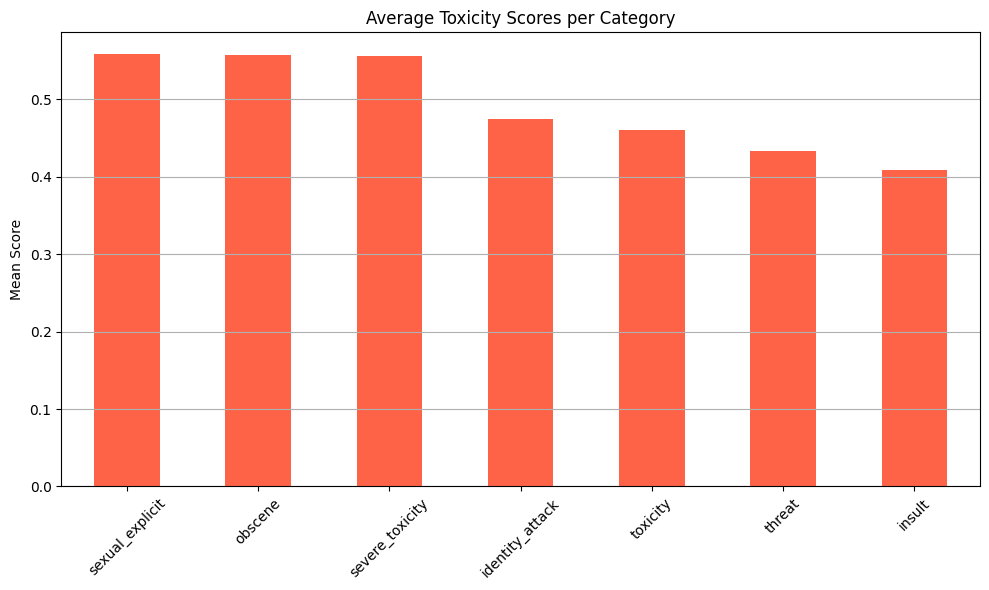

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
df_combined[TARGET_COLS].mean().sort_values(ascending=False).plot(kind="bar", color="tomato")
plt.title("Average Toxicity Scores per Category")
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


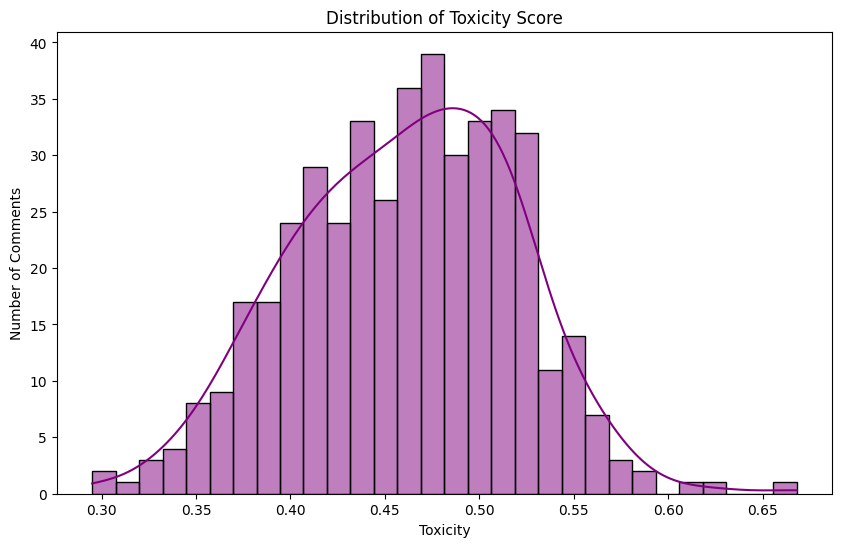

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df_combined["toxicity"], bins=30, kde=True, color="purple")
plt.title("Distribution of Toxicity Score")
plt.xlabel("Toxicity")
plt.ylabel("Number of Comments")
plt.show()

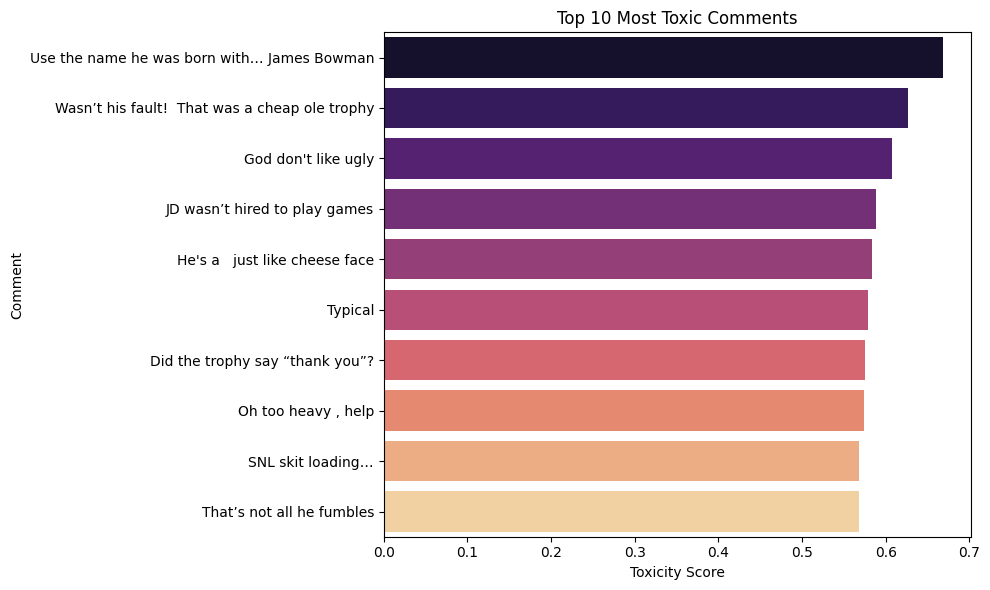

In [19]:
top_toxic = df_combined.sort_values(by="toxicity", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_toxic, x="toxicity", y="comment", palette="magma")
plt.title("Top 10 Most Toxic Comments")
plt.xlabel("Toxicity Score")
plt.ylabel("Comment")
plt.tight_layout()
plt.show()

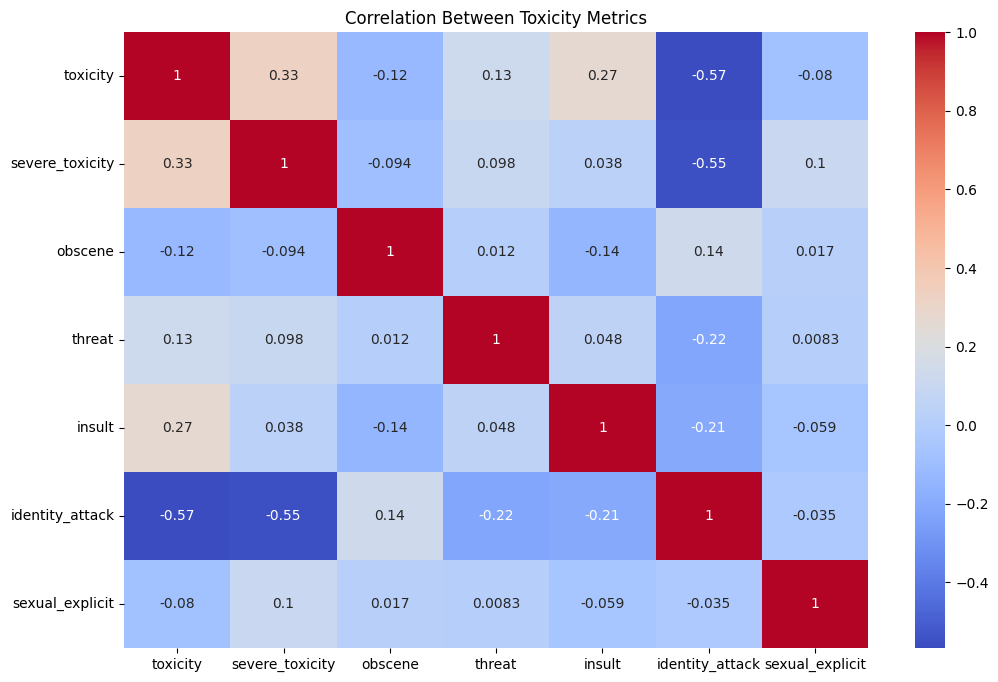

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_combined[TARGET_COLS].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Toxicity Metrics")
plt.show()